# Поиск токсичных комментариев

Входные данные - комментарии к товарам с разметкой о токсичности.

Здача - построить модель, которая будет классифицировать комментарии на позитивные и негативные со значением метрики качества *F1* не меньше 0.75. 

# Оглавление

* [1. Подготовка](#1.-Подготовка)
    * [Загрузка данных](#Загрузка-данных)
    * [Создание дополнительных признаков](#Создание-дополнительных-признаков)
    * [Удаление лишних символов, токенизация и лемматизация](#Удаление-лишних-символов,-токенизация-и-лемматизация)
    * [Создание признака - количество символов в тексте](#Создание-признака---количество-символов-в-тексте)
    * [Разделение на тестовую и обучающую выборки](#Разделение-на-тестовую-и-обучающую-выборки)
    * [Выводы (шаг 1)](#Выводы-(шаг-1))
* [2. Обучение](#2.-Обучение)
    * [TF-IDF](#TF-IDF)
    * [BERT](#BERT)
* [3. Тестирование](#3.-Тестирование)
* [4. Выводы](#4.-Выводы)

# 1. Подготовка

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk

from scipy.stats import mannwhitneyu

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stepa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stepa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
data = pd.read_csv('toxic_comments.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
data.head()

,text,toxic
0,Explanation\r\nWhy the edits made under my use...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
data['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

In [8]:
# cast to unicode
data['text'] = data['text'].values.astype('U')

## Создание дополнительных признаков

In [9]:
def feature_boxplot(feature, xlabel, threshold=None):
    """
    Function for plotting two boxplots for toxic and not toxic comments for chosen feature from dataset.
    Boxplots can be plotted on data with feature values smaller then chosen threshold.
    
    Parameters:
    feature (string): Dataset feature
    xlabel (string): x axis label
    threshold (numeric): Maximum feature value to plot boxplots with (default=None)
    """
    
    if threshold == None:
        threshold = data[feature].max()
    
    plt.figure(figsize=(15, 10))
    plt.boxplot([data.loc[(data['toxic'] == 0) & (data[feature] < threshold), feature], data.loc[(data['toxic'] == 1) & (data[feature] < threshold), feature]], vert=False, labels=['Not toxic', 'Toxic'])
    plt.xlabel(xlabel)
    plt.grid(linewidth=0.5)
    plt.title(f'{feature} distribution')
    plt.show()

In [10]:
def features_distr_by_toxicity(feature, ylabel, threshold=None):
    """
    Function for plotting two histograms for toxic and not toxic comments for chosen feature from dataset.
    Histograms can be plotted on data with feature values smaller then chosen threshold.
    
    Parameters:
    feature (string): Dataset feature
    xlabel (string): x axis label
    threshold (numeric): Maximum feature value to plot histograms with (default=None)
    """
    
    fig, (ax1, ax2) = plt.subplots(
        nrows=1, ncols=2,
        figsize=(20, 7)
    )
    
    if threshold == None:
        threshold = data[feature].max()
        bins = 200
    else:
        bins = threshold

    data.loc[(data['toxic'] == 0) & (data[feature] < threshold), feature].hist(bins=bins, ax=ax1)
    data.loc[(data['toxic'] == 1) & (data[feature] < threshold), feature].hist(bins=bins, ax=ax2)

    fig.suptitle(f'{feature} distibution for toxic and non-toxic comments', fontsize=16)

    ax1.set_xlabel('Texts')
    ax1.set_ylabel(ylabel)
    ax1.grid(linewidth=0.1)
    ax1.set_title('Non-toxic')

    ax2.set_xlabel('Texts')
    ax2.set_ylabel(ylabel)
    ax2.grid(linewidth=0.1)
    ax2.set_title('Toxic')
    plt.show()

### Количество прописных букв в комментарии

In [11]:
# number of uppercase letters in a comment
data['upper_letters'] = data['text'].apply(lambda text: len([symbol for symbol in text if symbol.isupper()]))

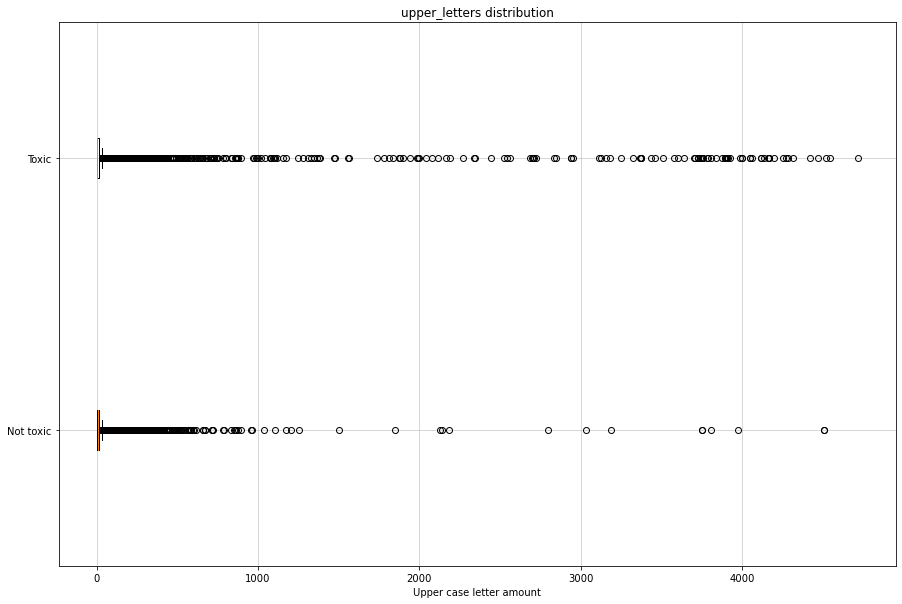

In [12]:
feature_boxplot('upper_letters', 'Upper case letter amount')

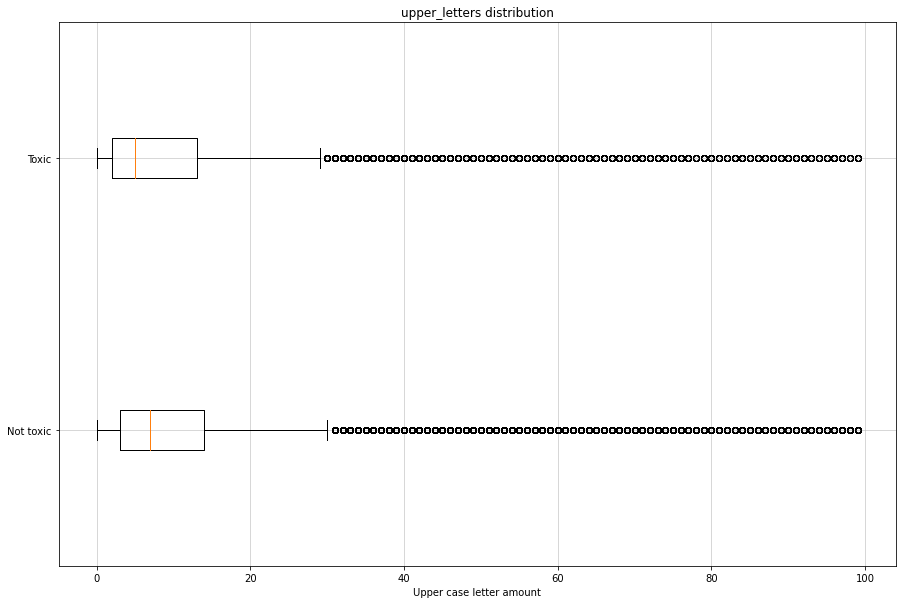

In [13]:
feature_boxplot('upper_letters', 'Upper case letter amount', 100)

In [14]:
data.loc[data['toxic'] == 0, 'upper_letters'].describe()

count    143346.000000
mean         14.236993
std          41.675348
min           0.000000
25%           3.000000
50%           7.000000
75%          15.000000
max        4512.000000
Name: upper_letters, dtype: float64

In [15]:
data.loc[data['toxic'] == 1, 'upper_letters'].describe()

count    16225.000000
mean        42.980770
std        274.873633
min          0.000000
25%          2.000000
50%          5.000000
75%         15.000000
max       4960.000000
Name: upper_letters, dtype: float64

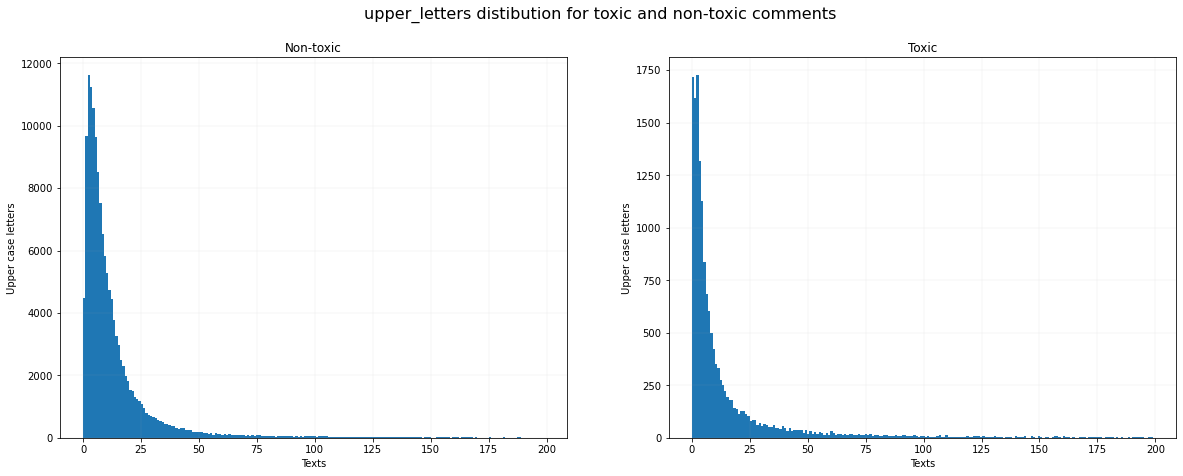

In [16]:
features_distr_by_toxicity('upper_letters', 'Upper case letters', threshold=200)

In [17]:
alpha=0.05

In [18]:
results = mannwhitneyu(
    data.loc[data['toxic'] == 0, 'upper_letters'],
    data.loc[data['toxic'] == 1, 'upper_letters'],
    alternative='less'
)

print('p-value:', results.pvalue)

if (results.pvalue < alpha) and (data.loc[data['toxic'] == 0, 'upper_letters'].mean() < data.loc[data['toxic'] == 1, 'upper_letters'].mean()):
    print("We reject the null hypothesis that the average number of upper letters in non-toxic comments is not less than in toxic ones - the average number of upper letters in non-toxic comments is less than in toxic ones.")
else:
    print("It's not possible to reject the null hypothesis, which states that the average number of upper letters in non-toxic comments is no less than in toxic ones.")

p-value: 1.0
It's not possible to reject the null hypothesis, which states that the average number of upper letters in non-toxic comments is no less than in toxic ones.


In [19]:
data.drop(columns=['upper_letters'], inplace=True)

### Количество восклицательных знаков в комментарии

In [20]:
# Number of exclamation points in a comment
data['exclamation_points'] = data['text'].apply(lambda text: len([symbol for symbol in text if symbol == '!']))

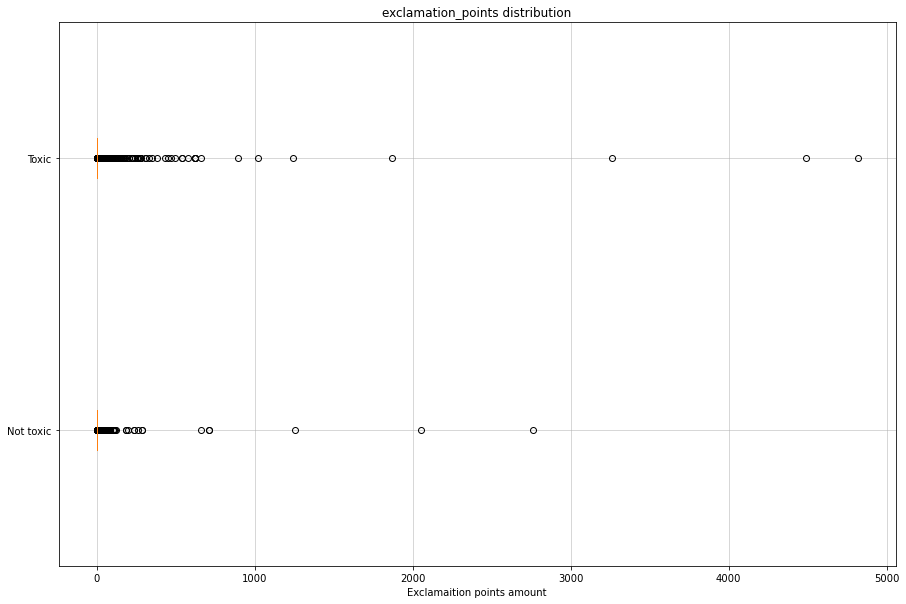

In [21]:
feature_boxplot('exclamation_points', 'Exclamaition points amount')

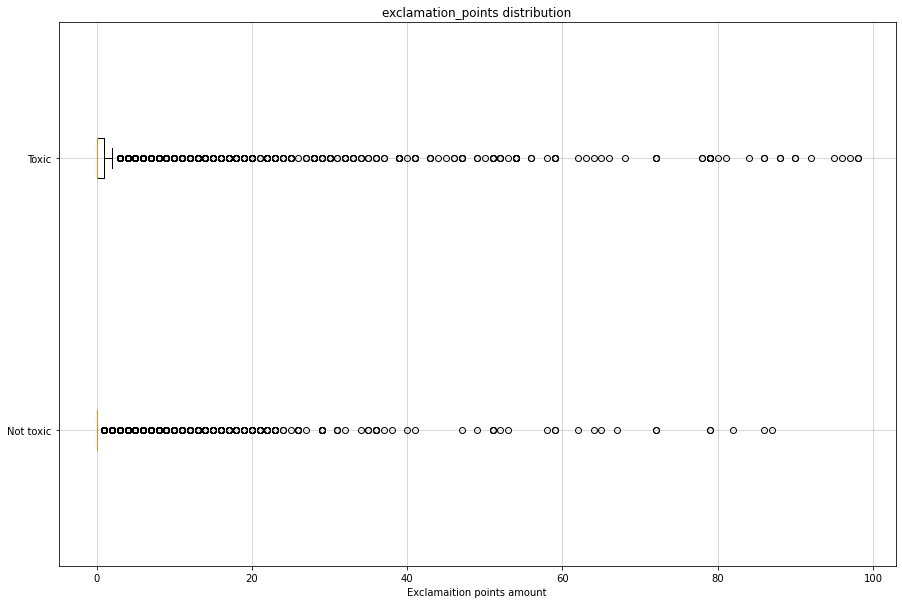

In [22]:
feature_boxplot('exclamation_points', 'Exclamaition points amount',  100)

In [23]:
data.loc[data['toxic'] == 0, 'exclamation_points'].describe()

count    143346.000000
mean          0.343442
std          10.450405
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2762.000000
Name: exclamation_points, dtype: float64

In [24]:
data.loc[data['toxic'] == 1, 'exclamation_points'].describe()

count    16225.000000
mean         3.472727
std         74.991734
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       4942.000000
Name: exclamation_points, dtype: float64

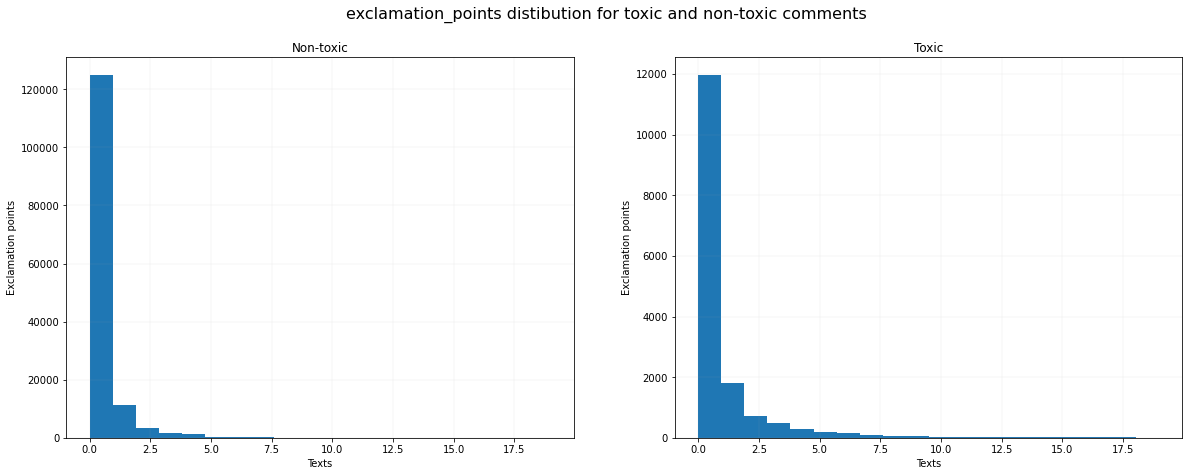

In [25]:
features_distr_by_toxicity('exclamation_points', 'Exclamation points', threshold=20)

In [26]:
results = mannwhitneyu(
    data.loc[data['toxic'] == 0, 'exclamation_points'],
    data.loc[data['toxic'] == 1, 'exclamation_points'],
    alternative='less'
)

print('p-value:', results.pvalue)

if (results.pvalue < alpha) and (data.loc[data['toxic'] == 0, 'exclamation_points'].mean() < data.loc[data['toxic'] == 1, 'exclamation_points'].mean()):
    print("We reject the null hypothesis that the average number of exclamation points in non-toxic comments is not less than in toxic ones - the average number of exclamation points in non-toxic comments is less than in toxic ones.")
else:
    print("It's not possible to reject the null hypothesis, which states that the average number of exclamation points in non-toxic comments is no less than in toxic ones.")

p-value: 0.0
We reject the null hypothesis that the average number of exclamation points in non-toxic comments is not less than in toxic ones - the average number of exclamation points in non-toxic comments is less than in toxic ones.


### Количество вопросительных знаков в комментарии

In [27]:
# Number of question marks in a comment
data['question_marks'] = data['text'].apply(lambda text: len([symbol for symbol in text if symbol == '?']))

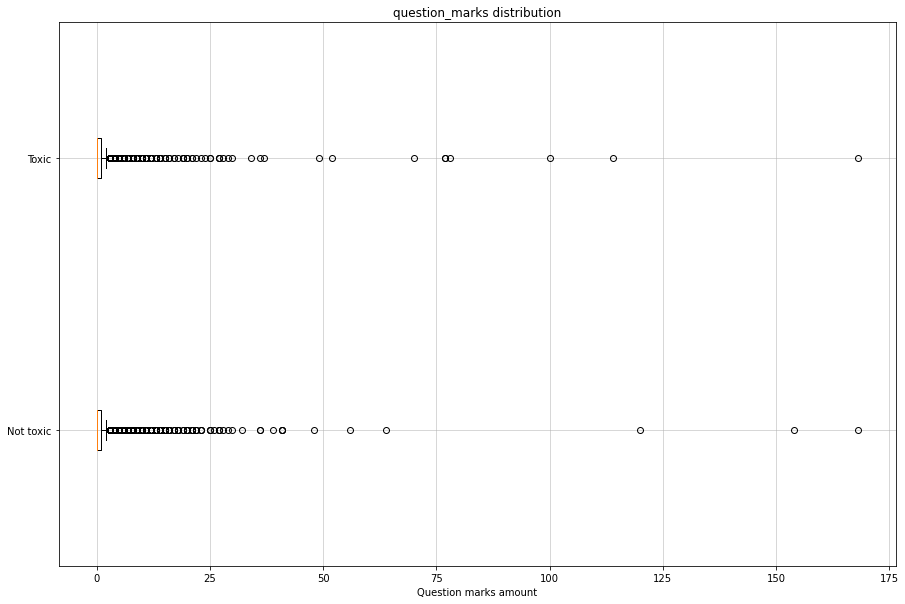

In [28]:
feature_boxplot('question_marks', 'Question marks amount')

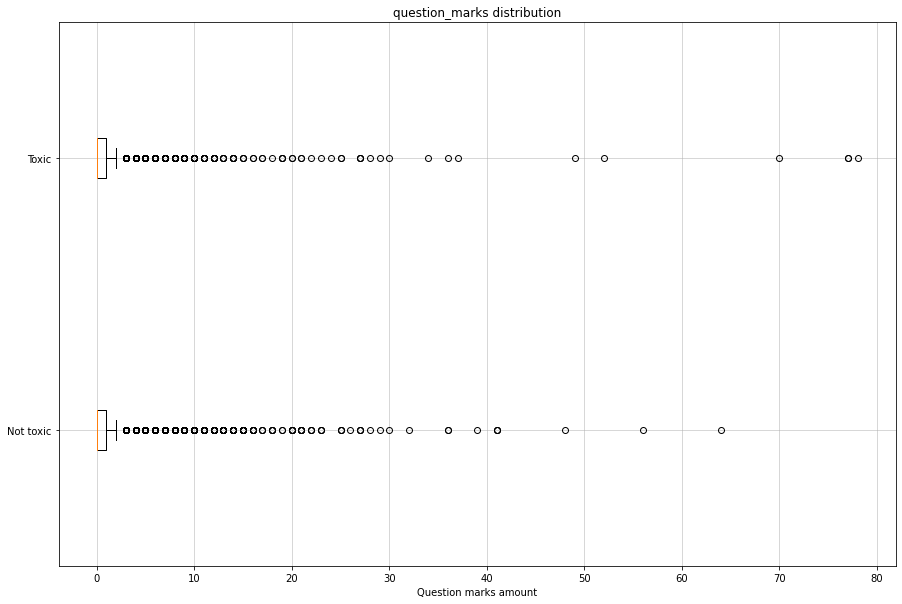

In [29]:
feature_boxplot('question_marks', 'Question marks amount', 100)

In [30]:
data.loc[data['toxic'] == 0, 'question_marks'].describe()

count    143346.000000
mean          0.433573
std           1.301386
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         168.000000
Name: question_marks, dtype: float64

In [31]:
data.loc[data['toxic'] == 1, 'question_marks'].describe()

count    16225.000000
mean         0.588043
std          3.142731
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        209.000000
Name: question_marks, dtype: float64

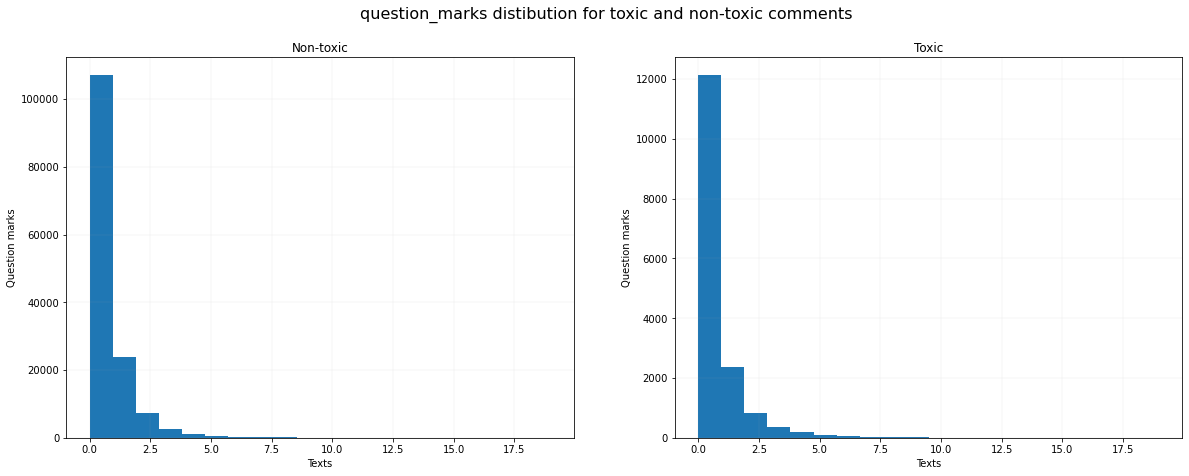

In [32]:
features_distr_by_toxicity('question_marks', 'Question marks', threshold=20)

In [33]:
results = mannwhitneyu(
    data.loc[data['toxic'] == 0, 'question_marks'],
    data.loc[data['toxic'] == 1, 'question_marks'],
    alternative='less'
)

print('p-value:', results.pvalue)

if (results.pvalue < alpha) and (data.loc[data['toxic'] == 0, 'question_marks'].mean() < data.loc[data['toxic'] == 1, 'question_marks'].mean()):
    print("We reject the null hypothesis that the average number of question marks in non-toxic comments is not less than in toxic ones - the average number of question marks in non-toxic comments is less than in toxic ones.")
else:
    print("It's not possible to reject the null hypothesis, which states that the average number of question marks in non-toxic comments is no less than in toxic ones.")

p-value: 0.07218351847770535
It's not possible to reject the null hypothesis, which states that the average number of question marks in non-toxic comments is no less than in toxic ones.


In [34]:
data.drop(columns=['question_marks'], inplace=True)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   text                159571 non-null  object
 1   toxic               159571 non-null  int64 
 2   exclamation_points  159571 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.7+ MB


## Удаление лишних символов, токенизация и лемматизация

In [36]:
tokenizer = nltk.tokenize.wordpunct_tokenize
wnl = nltk.WordNetLemmatizer()

In [37]:
def text_prepocessing(text):
    """
    Function for comments preprocessing:
    - converting text to lowercase;
    - removing unnecessary symbols (all, except letters and "'");
    - text tokenization;
    - text lemmatization;
    
    Parameters:
    text (string): Text
    """
    # converting text to lowercase and removing unnecessary symbols (all, except letters and "'")
    text_cleared = ' '.join(re.sub(r'[^a-z\' ]', ' ', text.lower()).split())
    
    # text tokenization and lemmatization
    tokens_lemmatized = [wnl.lemmatize(token) for token in tokenizer(text_cleared)]
    
    # raplacment of spaces near apostrophes
    tokens_lemmatized = re.sub(r'(\s\'\s)', '\'', ' '.join(tokens_lemmatized))
    
    return tokens_lemmatized

### Тестирование предобработки текста

In [38]:
print(data.loc[0, 'text'])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [39]:
text_prepocessing(data.loc[0, 'text'])

"explanation why the edits made under my username hardcore metallica fan were reverted they weren't vandalism just closure on some gas after i voted at new york doll fac and please don't remove the template from the talk page since i'm retired now"

In [40]:
print(data.loc[1, 'text'])

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)


In [41]:
text_prepocessing(data.loc[1, 'text'])

"d'aww he match this background colour i'm seemingly stuck with thanks talk january utc"

In [42]:
print(data.loc[2, 'text'])

Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.


In [43]:
text_prepocessing(data.loc[2, 'text'])

"hey man i'm really not trying to edit war it's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info"

In [44]:
print(data.loc[3, 'text'])

"
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.

There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "


In [45]:
text_prepocessing(data.loc[3, 'text'])

"more i can't make any real suggestion on improvement i wondered if the section statistic should be later on or a subsection of type of accident i think the reference may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else doe first if you have any preference for formatting style on reference or want to do it yourself please let me know there appears to be a backlog on article for review so i guess there may be a delay until a reviewer turn up it's listed in the relevant form eg wikipedia good article nomination transport"

### Предобработка текста

In [46]:
data['lemmatized_tokens'] = data['text'].apply(text_prepocessing)

In [47]:
data.head()

,text,toxic,exclamation_points,lemmatized_tokens
0,Explanation\r\nWhy the edits made under my use...,0,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,1,d'aww he match this background colour i'm seem...
2,"Hey man, I'm really not trying to edit war. It...",0,0,hey man i'm really not trying to edit war it's...
3,"""\r\nMore\r\nI can't make any real suggestions...",0,0,more i can't make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,0,you sir are my hero any chance you remember wh...


## Создание признака - количество символов в тексте

In [48]:
data['length'] = data['text'].apply(len)
data['length'].head()

0    265
1    112
2    233
3    626
4     67
Name: length, dtype: int64

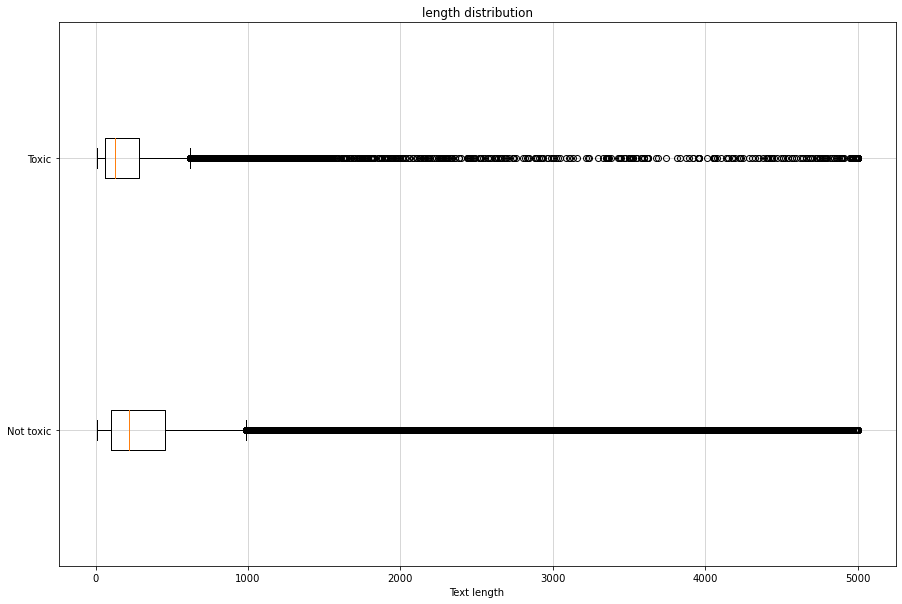

In [49]:
feature_boxplot('length', xlabel='Text length')

In [50]:
data.loc[data['toxic'] == 0, 'length'].describe()

count    143346.000000
mean        406.885138
std         590.177739
min           6.000000
25%         103.000000
50%         218.000000
75%         455.000000
max        5000.000000
Name: length, dtype: float64

In [51]:
data.loc[data['toxic'] == 1, 'length'].describe()

count    16225.000000
mean       305.672604
std        623.040359
min          8.000000
25%         62.000000
50%        129.000000
75%        285.000000
max       5000.000000
Name: length, dtype: float64

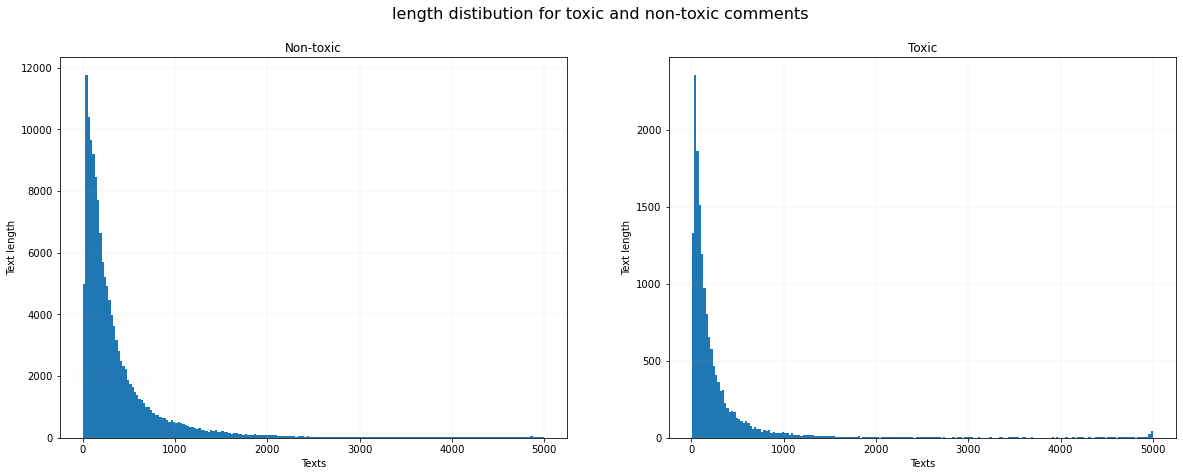

In [52]:
features_distr_by_toxicity('length', 'Text length')

In [53]:
results = mannwhitneyu(
    data.loc[data['toxic'] == 0, 'length'],
    data.loc[data['toxic'] == 1, 'length'],
    alternative='greater'
)

print('p-value:', results.pvalue)

if (results.pvalue < alpha) and (data.loc[data['toxic'] == 0, 'length'].mean() > data.loc[data['toxic'] == 1, 'length'].mean()):
    print("We reject the null hypothesis that the average length of non-toxic comments is not greater than of toxic one - the average number of length of non-toxic comments is greater than of toxic ones.")
else:
    print("It's not possible to reject the null hypothesis, which states that the average length of non-toxic comments is no greater than in toxic ones.")

p-value: 0.0
We reject the null hypothesis that the average length of non-toxic comments is not greater than of toxic one - the average number of length of non-toxic comments is greater than of toxic ones.


## Разделение на тестовую и обучающую выборки

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [56]:
train.shape, test.shape

((127656, 5), (31915, 5))

## Выводы (шаг 1)

Файл с данными состоит из 2 столбцов (1 со строками и 1 с целыми числами) и 159571 записей.
В ходе предобработки комментарии были:
 - приведенных к нижнему регистру;
 - очищены от всех лишних символов. Были оставлены только буквы и апострофы, т.к. они имеют важное значение в английском языке;
 - токенезированы с помощью токенизатора wordpunct_tokenize из библиотеки NLTK;
 - лемматизированы с помощью лемматизатора WordNetLemmatizer из библиотеки NLTK.

Также в ходе предобработки было проведено сравнение токсичных и не токсичных комментариев по различным параметрам. Было выдвинуто предположение, что токсичные и не токсичные комментарии будут значимо отличаться по этим параметрам:
 - количество прописных букв, восклицательных и вопросительных знаков - были выдвинуты гипотезы, гласящие, что в токсичных комментариях будет больше каждых из указанных символов, т.к. таким образом можно выразить сильные негативные эмоции;
 - длина текста - была выдвинуты гипотеза, гласящие, что длина токсичных комментариев будет меньше, т.к. люди более коротко излагают свои негативные мысли в порывах ярости и не утруждают себя написанием больших сообщений. Все гипотезы были проверены с помощью теста Манна-Уитни (т.к. все указанные признаки распределены не нормально). 
 
В результате анализа диаграмм размаха и проверки гипотез были сделаны следующие выводы:
 - гипотезы о количестве восклицательных знаков и длине текста подтвердились - признаки были оставлены для использования в моделях;
 - количество прописных букв отличается, причем в токсичных комментариях оно меньше, а не больше, как предполагалось. Предположительно, это можно объяснить большей длиной текстов (количеством предложений) в не токсичных комментариях. В связи с этим решено было не использовать данный признак;
 - гипотеза о различие количество вопросительных знаков также была отвергнута, а признак также было решено не использовать.

# 2. Обучение

## TF-IDF

In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

In [58]:
features = train.drop(columns=['text', 'toxic'])
target = train['toxic']

In [59]:
features.head()

,exclamation_points,lemmatized_tokens,length
140030,1,grandma terri should burn in trash grandma ter...,112
159124,0,may utc it would be easiest if you were to adm...,503
60006,0,the objectivity of this discussion is doubtful...,4631
65432,0,shelly shock shelly shock is,37
154979,0,i do not care refer to ong teng cheong talk pa...,243


In [60]:
# features transfromation - TF-IDF for text and scaling for other features
ct_tfidf = ColumnTransformer([
    ("text", TfidfVectorizer(stop_words={'english'}), 1),
    ("numeric", StandardScaler(), [0, 2])
])

### Логистическая регрессия

In [501]:
pipe_logreg = Pipeline([('columns_transfrom', ct_tfidf), ('logreg', LogisticRegression(class_weight='balanced', n_jobs=4))])

In [502]:
# Hyperparameters values grid
param_grid = {
    'logreg__C': np.geomspace(1, 100, 70),
}

In [503]:
# GridSearch settings
search_logreg = GridSearchCV(pipe_logreg, param_grid, return_train_score=True, scoring='f1', verbose=5, n_jobs=-1)

In [504]:
# Best hyperparameters values search
search_logreg.fit(features, target)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed: 30.5min finished


GridSearchCV(estimator=Pipeline(steps=[('columns_transfrom',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(stop_words={'english'}),
                                                                         1),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         [0,
                                                                          2])])),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           n_jobs=4))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([  1.        ,   1.0690192 ,   1.14280206,   1.22167735,
 

In [534]:
logreg_results = pd.DataFrame(search_logreg.cv_results_)[(pd.DataFrame(search_logreg.cv_results_)['mean_train_score'] - pd.DataFrame(search_logreg.cv_results_)['mean_test_score']) < 0.1].sort_values('rank_test_score')
logreg_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
14,22.788546,1.227592,3.831998,0.421505,2.54564,{'logreg__C': 2.545640673860415},0.763199,0.755259,0.757068,0.764485,...,0.760700,0.003772,57,0.868140,0.860279,0.860601,0.858424,0.852709,0.860031,0.004946
12,23.330037,1.995738,3.173924,0.148333,2.22754,{'logreg__C': 2.2275429519995575},0.761856,0.753154,0.753574,0.761986,...,0.758705,0.004379,58,0.862326,0.856020,0.853975,0.855339,0.856713,0.856874,0.002872
11,22.236463,1.487804,3.431518,0.209643,2.08373,{'logreg__C': 2.08372585114296},0.762019,0.755297,0.752105,0.757728,...,0.758312,0.004448,59,0.861839,0.857538,0.854202,0.845729,0.855624,0.854986,0.005295
10,24.604007,0.381258,3.296720,0.333685,1.94919,{'logreg__C': 1.9491940296028527},0.761352,0.753450,0.753229,0.760311,...,0.757981,0.003814,60,0.856230,0.852919,0.845479,0.851440,0.852892,0.851792,0.003526
9,23.493033,1.880928,3.219922,0.352372,1.82335,{'logreg__C': 1.823348000868441},0.760866,0.753909,0.751216,0.761065,...,0.757668,0.004257,61,0.855775,0.852186,0.850394,0.850707,0.849042,0.851621,0.002305
7,25.360589,0.278525,3.124324,0.086528,1.59551,{'logreg__C': 1.595506400444829},0.757730,0.752462,0.750628,0.761134,...,0.756710,0.004461,62,0.850804,0.848422,0.846785,0.846816,0.845368,0.847639,0.001854
8,23.437635,1.796461,3.463917,0.331762,1.70563,{'logreg__C': 1.705626983142528},0.759032,0.750337,0.749708,0.758260,...,0.755835,0.004897,63,0.854289,0.844825,0.845601,0.845700,0.848180,0.847719,0.003473
6,24.117218,2.283721,3.377720,0.324859,1.4925,{'logreg__C': 1.4924955450518296},0.755202,0.754109,0.749666,0.757438,...,0.755376,0.003588,64,0.846937,0.846689,0.843808,0.842040,0.842114,0.844318,0.002135
5,25.742579,1.273461,3.323520,0.320440,1.39614,{'logreg__C': 1.396135390856794},0.754564,0.751389,0.749037,0.757739,...,0.754410,0.003827,65,0.843592,0.839828,0.842718,0.841315,0.837301,0.840951,0.002228
4,25.231992,2.261529,3.362919,0.353564,1.306,{'logreg__C': 1.3059965479060531},0.753413,0.751305,0.746229,0.757972,...,0.753560,0.004617,66,0.841531,0.837924,0.834470,0.838047,0.838146,0.838024,0.002234


In [539]:
# Best hyperparameters values
logreg_results.head(1)[['param_logreg__C']]

,param_logreg__C
14,2.54564


In [575]:
print('F1 with logistic regression - {:.3f}'.format(float(logreg_results.head(1)['mean_test_score'])))

F1 with logistic regression - 0.761


### Дерево решений

#### Часть 1

In [62]:
pipe_tree = Pipeline([('columns_transfrom', ct_tfidf), ('tree', DecisionTreeClassifier(class_weight='balanced', random_state=42))])

In [463]:
# Hyperparameters values grid
param_grid = {
    'tree__max_depth': np.arange(1, 11),
    'tree__min_samples_split': np.arange(2, 223, 20),
    'tree__min_samples_leaf': np.arange(1, 26, 5)
}

In [464]:
# GridSearch settings
search_tree = GridSearchCV(pipe_tree, param_grid, return_train_score=True, scoring='f1', verbose=5, n_jobs=-1)

In [465]:
# Best hyperparameters values search
search_tree.fit(features, target)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 40.7min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 56.4min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 75.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 97.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 122.6min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 152.5min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 186.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 223.6min finished


GridSearchCV(estimator=Pipeline(steps=[('columns_transfrom',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(stop_words={'english'}),
                                                                         1),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         [0,
                                                                          2])])),
                                       ('tree',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10

In [535]:
tree_results = pd.DataFrame(search_tree.cv_results_)[(pd.DataFrame(search_tree.cv_results_)['mean_train_score'] - pd.DataFrame(search_tree.cv_results_)['mean_test_score']) < 0.1].sort_values('rank_test_score')
tree_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__max_depth,param_tree__min_samples_leaf,param_tree__min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
502,25.125394,0.537503,2.999127,0.099588,9,6,202,"{'tree__max_depth': 9, 'tree__min_samples_leaf...",0.455417,0.481219,...,0.468116,0.015917,1,0.466072,0.486275,0.462697,0.473329,0.502470,0.478169,0.014597
500,24.933998,0.943244,2.991728,0.129308,9,6,162,"{'tree__max_depth': 9, 'tree__min_samples_leaf...",0.455131,0.481001,...,0.467867,0.016222,2,0.466180,0.486456,0.463569,0.473786,0.503865,0.478771,0.014854
501,24.256614,0.458688,3.081326,0.160715,9,6,182,"{'tree__max_depth': 9, 'tree__min_samples_leaf...",0.455417,0.480241,...,0.467838,0.015725,3,0.466072,0.486420,0.462899,0.473688,0.502470,0.478310,0.014547
503,23.936822,0.715576,3.032127,0.191298,9,6,222,"{'tree__max_depth': 9, 'tree__min_samples_leaf...",0.455620,0.479724,...,0.467723,0.015491,4,0.465872,0.484893,0.462697,0.472938,0.501697,0.477619,0.014250
490,24.946997,0.968675,2.989529,0.059734,9,1,202,"{'tree__max_depth': 9, 'tree__min_samples_leaf...",0.454306,0.479456,...,0.467591,0.015520,5,0.467046,0.487550,0.464222,0.474577,0.503807,0.479440,0.014617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,15.308231,0.180074,3.044927,0.170992,2,1,182,"{'tree__max_depth': 2, 'tree__min_samples_leaf...",0.257912,0.274564,...,0.261923,0.008667,589,0.256997,0.264904,0.258492,0.257635,0.266144,0.260835,0.003878
71,15.448628,0.253128,3.060325,0.025942,2,1,222,"{'tree__max_depth': 2, 'tree__min_samples_leaf...",0.257912,0.274564,...,0.261923,0.008667,589,0.256997,0.264904,0.258492,0.257635,0.266144,0.260835,0.003878
60,15.604222,0.181581,3.020127,0.137125,2,1,2,"{'tree__max_depth': 2, 'tree__min_samples_leaf...",0.257912,0.274564,...,0.261923,0.008667,589,0.256997,0.264904,0.258492,0.257635,0.266144,0.260835,0.003878
67,15.097836,0.236491,2.979128,0.174929,2,1,142,"{'tree__max_depth': 2, 'tree__min_samples_leaf...",0.257912,0.274564,...,0.261923,0.008667,589,0.256997,0.264904,0.258492,0.257635,0.266144,0.260835,0.003878


In [545]:
# Best hyperparameters values
tree_results.head(1)[['param_tree__max_depth', 'param_tree__min_samples_leaf', 'param_tree__min_samples_split']]

,param_tree__max_depth,param_tree__min_samples_leaf,param_tree__min_samples_split
502,9,6,202


#### Часть 2

In [524]:
# Hyperparameters values grid
param_grid_2 = {
    'tree__max_depth': np.arange(11, 32, 4),
    'tree__min_samples_split': np.arange(2, 300, 80),
    'tree__min_samples_leaf': np.arange(1, 22, 5)
}

In [525]:
# GridSearch settings
search_tree_2 = GridSearchCV(pipe_tree, param_grid_2, return_train_score=True, scoring='f1', verbose=5, n_jobs=-1)

In [526]:
# Best hyperparameters values search
search_tree_2.fit(features, target)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 58.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 86.8min finished


GridSearchCV(estimator=Pipeline(steps=[('columns_transfrom',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(stop_words={'english'}),
                                                                         1),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         [0,
                                                                          2])])),
                                       ('tree',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': array([11, 15, 19, 23, 27, 31]),
            

In [536]:
tree_results_2 = pd.DataFrame(search_tree_2.cv_results_)[(pd.DataFrame(search_tree_2.cv_results_)['mean_train_score'] - pd.DataFrame(search_tree_2.cv_results_)['mean_test_score']) < 0.1].sort_values('rank_test_score')
tree_results_2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__max_depth,param_tree__min_samples_leaf,param_tree__min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
82,61.694737,1.614012,3.226722,0.112904,27,1,162,"{'tree__max_depth': 27, 'tree__min_samples_lea...",0.501153,0.521363,...,0.508686,0.009146,12,0.601574,0.605585,0.589363,0.590871,0.614366,0.600352,0.009337
103,68.370395,0.792282,3.085326,0.196402,31,1,242,"{'tree__max_depth': 31, 'tree__min_samples_lea...",0.500996,0.518304,...,0.508540,0.007320,13,0.597566,0.605553,0.584946,0.586921,0.599254,0.594848,0.007775
83,58.363191,1.155726,3.064327,0.094656,27,1,242,"{'tree__max_depth': 27, 'tree__min_samples_lea...",0.497690,0.522101,...,0.507185,0.009495,15,0.582671,0.596700,0.575551,0.575119,0.590230,0.584054,0.008392
61,62.037604,2.560946,3.091525,0.100631,23,1,82,"{'tree__max_depth': 23, 'tree__min_samples_lea...",0.497769,0.518206,...,0.505834,0.009605,16,0.610974,0.604265,0.584566,0.603096,0.616674,0.603915,0.010843
44,56.384187,2.347188,3.426303,0.290428,19,6,2,"{'tree__max_depth': 19, 'tree__min_samples_lea...",0.494144,0.508674,...,0.504876,0.005532,18,0.590737,0.583615,0.580082,0.578421,0.587942,0.584159,0.004635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,64.778310,1.799783,3.266322,0.196021,31,21,162,"{'tree__max_depth': 31, 'tree__min_samples_lea...",0.462268,0.476855,...,0.472477,0.012162,116,0.540367,0.548894,0.544093,0.546114,0.527263,0.541346,0.007570
37,38.335902,1.109670,3.567715,0.236258,15,21,82,"{'tree__max_depth': 15, 'tree__min_samples_lea...",0.471385,0.485757,...,0.472214,0.009465,117,0.518872,0.517457,0.510013,0.486235,0.516116,0.509739,0.012134
39,38.126329,0.924443,3.748515,0.476422,15,21,242,"{'tree__max_depth': 15, 'tree__min_samples_lea...",0.473468,0.488742,...,0.470552,0.011169,118,0.511290,0.515085,0.501182,0.478095,0.501984,0.501527,0.012873
38,38.429116,1.109452,3.383718,0.164803,15,21,162,"{'tree__max_depth': 15, 'tree__min_samples_lea...",0.472540,0.487772,...,0.470517,0.010687,119,0.513030,0.515078,0.504491,0.480878,0.505326,0.503761,0.012171


In [546]:
# Best hyperparameters values
tree_results_2.head(1)[['param_tree__max_depth', 'param_tree__min_samples_leaf', 'param_tree__min_samples_split']]

,param_tree__max_depth,param_tree__min_samples_leaf,param_tree__min_samples_split
82,27,1,162


#### Часть 3

In [560]:
# Hyperparameters values grid
param_grid_3 = {
    'tree__max_depth': np.arange(32, 100, 15),
    'tree__min_samples_split': np.arange(2, 500, 100),
    'tree__min_samples_leaf': np.arange(1, 22, 5)
}

In [561]:
# GridSearch settings
search_tree_3 = GridSearchCV(pipe_tree, param_grid_3, return_train_score=True, scoring='f1', verbose=5, n_jobs=-1)

In [562]:
# Best hyperparameters values search
search_tree_3.fit(features, target)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 54.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 94.9min
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed: 142.8min finished


GridSearchCV(estimator=Pipeline(steps=[('columns_transfrom',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(stop_words={'english'}),
                                                                         1),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         [0,
                                                                          2])])),
                                       ('tree',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': array([32, 47, 62, 77, 92]),
                

In [563]:
tree_results_3 = pd.DataFrame(search_tree_3.cv_results_)[(pd.DataFrame(search_tree_3.cv_results_)['mean_train_score'] - pd.DataFrame(search_tree_3.cv_results_)['mean_test_score']) < 0.1].sort_values('rank_test_score')
tree_results_3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__max_depth,param_tree__min_samples_leaf,param_tree__min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,69.227042,0.688347,3.059933,0.062705,32,1,202,"{'tree__max_depth': 32, 'tree__min_samples_lea...",0.501602,0.523557,...,0.510752,0.008258,17,0.607239,0.616313,0.595020,0.595447,0.612497,0.605303,0.008713
3,66.345993,1.818779,3.083126,0.056140,32,1,302,"{'tree__max_depth': 32, 'tree__min_samples_lea...",0.494408,0.515718,...,0.505605,0.008457,20,0.586296,0.595229,0.578292,0.574803,0.594867,0.585897,0.008350
4,64.948632,1.278289,3.089926,0.145807,32,1,402,"{'tree__max_depth': 32, 'tree__min_samples_lea...",0.488324,0.516016,...,0.502833,0.010301,25,0.575145,0.588995,0.560871,0.567075,0.579988,0.574415,0.009813
28,81.609231,2.861002,3.090325,0.125790,47,1,302,"{'tree__max_depth': 47, 'tree__min_samples_lea...",0.486311,0.504993,...,0.500770,0.007837,27,0.591788,0.603048,0.593248,0.592925,0.600844,0.596371,0.004631
7,64.639397,2.126702,3.147124,0.200499,32,6,202,"{'tree__max_depth': 32, 'tree__min_samples_lea...",0.483924,0.509952,...,0.498817,0.008866,29,0.581418,0.593773,0.579600,0.574134,0.590840,0.583953,0.007289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,97.450065,6.059775,3.091325,0.156642,92,16,202,"{'tree__max_depth': 92, 'tree__min_samples_lea...",0.457449,0.462814,...,0.458066,0.006400,121,0.538811,0.544349,0.547422,0.536776,0.533254,0.540122,0.005123
118,96.222478,4.349761,3.199323,0.345632,92,16,302,"{'tree__max_depth': 92, 'tree__min_samples_lea...",0.459228,0.461574,...,0.457432,0.007650,122,0.531860,0.529345,0.527592,0.530011,0.523327,0.528427,0.002893
98,90.122712,4.310648,3.733612,0.387523,77,21,302,"{'tree__max_depth': 77, 'tree__min_samples_lea...",0.456784,0.457933,...,0.457400,0.005549,123,0.524051,0.526075,0.523123,0.518955,0.516784,0.521798,0.003416
124,66.279000,10.272558,2.413545,0.662209,92,21,402,"{'tree__max_depth': 92, 'tree__min_samples_lea...",0.455585,0.451768,...,0.456408,0.006293,124,0.518876,0.515016,0.516219,0.516839,0.511209,0.515632,0.002540


In [564]:
# Best hyperparameters values
tree_results_3.head(1)[['param_tree__max_depth', 'param_tree__min_samples_leaf', 'param_tree__min_samples_split']]

,param_tree__max_depth,param_tree__min_samples_leaf,param_tree__min_samples_split
2,32,1,202


In [576]:
print('F1 with decision tree - {:.3f}'.format(float(tree_results_3.head(1)['mean_test_score'])))

F1 with decision tree - 0.511


### Случайный лес

#### Часть 1

In [73]:
# Pipline with scaler and model
pipe_forest = Pipeline([('columns_transfrom', ct_tfidf), ('forest', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=4))])

In [480]:
# Hyperparameters values grid
param_grid = {
    'forest__n_estimators': np.arange(50, 201, 75),
    'forest__max_depth': np.arange(1, 16),
    'forest__min_samples_split': np.arange(2, 83, 40),
    'forest__min_samples_leaf': np.arange(1, 12, 5)
}

In [481]:
# GridSearch settings
search_forest = GridSearchCV(pipe_forest, param_grid, return_train_score=True, scoring='f1', verbose=5, n_jobs=-1)

In [482]:
# Best hyperparameters values search
search_forest.fit(features, target)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 38.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 55.4min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 76.8min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 102.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 131.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 167.1min
[Parallel(n_jobs=-1)]: Done 2025 out of 2025 | elapsed: 192.5min finished


GridSearchCV(estimator=Pipeline(steps=[('columns_transfrom',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(stop_words={'english'}),
                                                                         1),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         [0,
                                                                          2])])),
                                       ('forest',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=4,
                                                               random_state=42))]),
             n_jobs=-1,
             p

In [577]:
forest_results = pd.DataFrame(search_forest.cv_results_)[(pd.DataFrame(search_forest.cv_results_)['mean_train_score'] - pd.DataFrame(search_forest.cv_results_)['mean_test_score']) < 0.1].sort_values('rank_test_score')
forest_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_forest__max_depth,param_forest__min_samples_leaf,param_forest__min_samples_split,param_forest__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
385,23.250038,1.422855,5.589466,1.601000,15,1,82,125,"{'forest__max_depth': 15, 'forest__min_samples...",0.348543,...,0.362273,0.008163,1,0.374017,0.384063,0.386124,0.378141,0.379611,0.380391,0.004305
386,31.243264,2.358872,5.820861,0.456158,15,1,82,200,"{'forest__max_depth': 15, 'forest__min_samples...",0.347186,...,0.360776,0.008945,2,0.372018,0.385681,0.383501,0.374768,0.382527,0.379699,0.005321
379,26.659556,1.223121,6.880841,1.801531,15,1,2,125,"{'forest__max_depth': 15, 'forest__min_samples...",0.347871,...,0.360290,0.007931,3,0.380088,0.388659,0.385879,0.380552,0.384062,0.383848,0.003235
384,22.339060,1.623665,4.284297,0.454234,15,1,82,50,"{'forest__max_depth': 15, 'forest__min_samples...",0.337498,...,0.359878,0.015192,4,0.365498,0.379380,0.391782,0.367064,0.387370,0.378219,0.010538
382,24.315754,1.077706,5.237475,0.514806,15,1,42,125,"{'forest__max_depth': 15, 'forest__min_samples...",0.349258,...,0.359734,0.006393,5,0.374294,0.383645,0.383951,0.375648,0.379387,0.379385,0.003972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,19.377202,0.685065,4.544916,0.203222,1,6,82,50,"{'forest__max_depth': 1, 'forest__min_samples_...",0.269213,...,0.274157,0.016967,397,0.273268,0.260069,0.298737,0.260262,0.277392,0.273946,0.014190
21,18.459953,0.785471,3.677312,0.261625,1,11,42,50,"{'forest__max_depth': 1, 'forest__min_samples_...",0.269213,...,0.274157,0.016967,397,0.273268,0.260069,0.298737,0.260262,0.277392,0.273946,0.014190
24,17.793171,0.465318,3.864506,0.395576,1,11,82,50,"{'forest__max_depth': 1, 'forest__min_samples_...",0.269213,...,0.274157,0.016967,397,0.273268,0.260069,0.298737,0.260262,0.277392,0.273946,0.014190
6,17.454379,0.651137,4.548091,0.858622,1,1,82,50,"{'forest__max_depth': 1, 'forest__min_samples_...",0.269213,...,0.274157,0.016967,397,0.273268,0.260069,0.298737,0.260262,0.277392,0.273946,0.014190


In [578]:
# Best hyperparameters values
forest_results.head(1)[['param_forest__max_depth', 'param_forest__min_samples_leaf', 'param_forest__min_samples_split', 'param_forest__n_estimators']]

,param_forest__max_depth,param_forest__min_samples_leaf,param_forest__min_samples_split,param_forest__n_estimators
385,15,1,82,125


#### Часть 2

In [590]:
# Hyperparameters values grid
param_grid_2 = {
    'forest__n_estimators': np.arange(50, 201, 75),
    'forest__max_depth': np.arange(16, 50, 5),
    'forest__min_samples_split': np.arange(2, 83, 40),
    'forest__min_samples_leaf': np.arange(1, 12, 5)
}

In [591]:
# GridSearch settings
search_forest_2 = GridSearchCV(pipe_forest, param_grid_2, return_train_score=True, scoring='f1', verbose=5, n_jobs=-1)

In [592]:
# Best hyperparameters values search
search_forest_2.fit(features, target)

Fitting 5 folds for each of 189 candidates, totalling 945 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 54.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 85.0min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 129.7min
[Parallel(n_jobs=-1)]: Done 945 out of 945 | elapsed: 141.1min finished


GridSearchCV(estimator=Pipeline(steps=[('columns_transfrom',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(stop_words={'english'}),
                                                                         1),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         [0,
                                                                          2])])),
                                       ('forest',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=4,
                                                               random_state=42))]),
             n_jobs=-1,
             p

In [593]:
forest_results_2 = pd.DataFrame(search_forest_2.cv_results_)[(pd.DataFrame(search_forest_2.cv_results_)['mean_train_score'] - pd.DataFrame(search_forest_2.cv_results_)['mean_test_score']) < 0.1].sort_values('rank_test_score')
forest_results_2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_forest__max_depth,param_forest__min_samples_leaf,param_forest__min_samples_split,param_forest__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
170,76.897554,5.016836,8.657696,3.410937,46,1,82,200,"{'forest__max_depth': 46, 'forest__min_samples...",0.463521,...,0.473456,0.007442,1,0.568150,0.574398,0.573068,0.567564,0.566423,0.569921,0.003190
169,64.330062,4.272059,9.030783,2.388698,46,1,82,125,"{'forest__max_depth': 46, 'forest__min_samples...",0.460997,...,0.471297,0.008379,3,0.565781,0.570652,0.572362,0.562350,0.560329,0.566295,0.004631
168,50.195802,16.149425,8.755009,2.632102,46,1,82,50,"{'forest__max_depth': 46, 'forest__min_samples...",0.456081,...,0.465652,0.007276,5,0.555828,0.556587,0.568888,0.549833,0.544495,0.555126,0.008162
143,68.057430,2.976637,8.866232,2.228312,41,1,82,200,"{'forest__max_depth': 41, 'forest__min_samples...",0.448681,...,0.456273,0.007824,9,0.539825,0.536592,0.546820,0.537667,0.537846,0.539750,0.003686
142,55.018281,3.469508,9.136385,3.059220,41,1,82,125,"{'forest__max_depth': 41, 'forest__min_samples...",0.448832,...,0.456232,0.006189,10,0.539443,0.534951,0.546146,0.535339,0.533565,0.537889,0.004570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,21.729876,1.115711,6.296248,0.995521,16,11,2,125,"{'forest__max_depth': 16, 'forest__min_samples...",0.351554,...,0.358985,0.004409,185,0.366448,0.370253,0.369314,0.369093,0.368649,0.368751,0.001265
22,22.581282,1.426867,6.564841,1.645198,16,11,42,125,"{'forest__max_depth': 16, 'forest__min_samples...",0.352482,...,0.358833,0.004449,186,0.369172,0.370889,0.371440,0.367495,0.368354,0.369470,0.001492
18,21.523281,0.833994,4.272497,0.337375,16,11,2,50,"{'forest__max_depth': 16, 'forest__min_samples...",0.343675,...,0.358721,0.011532,187,0.360829,0.368299,0.376203,0.357818,0.378207,0.368271,0.008078
21,20.597902,0.681309,4.123901,0.329276,16,11,42,50,"{'forest__max_depth': 16, 'forest__min_samples...",0.340958,...,0.358504,0.013125,188,0.360985,0.369813,0.381076,0.355045,0.376360,0.368656,0.009582


In [594]:
# Best hyperparameters values
forest_results_2.head(1)[['param_forest__max_depth', 'param_forest__min_samples_leaf', 'param_forest__min_samples_split', 'param_forest__n_estimators']]

,param_forest__max_depth,param_forest__min_samples_leaf,param_forest__min_samples_split,param_forest__n_estimators
170,46,1,82,200


#### Часть 3

In [215]:
# Hyperparameters values grid
param_grid_3 = {
    'forest__n_estimators': np.arange(50, 201, 75),
    'forest__max_depth': np.arange(47, 200, 25),
    'forest__min_samples_split': np.arange(2, 83, 40),
    'forest__min_samples_leaf': np.arange(1, 12, 5)
}

In [216]:
# GridSearch settings
search_forest_3 = GridSearchCV(pipe_forest, param_grid_3, return_train_score=True, scoring='f1', verbose=5, n_jobs=-1)

In [217]:
# Best hyperparameters values search
search_forest_3.fit(features, target)

Fitting 5 folds for each of 189 candidates, totalling 945 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 65.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 135.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 209.0min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 328.8min
[Parallel(n_jobs=-1)]: Done 945 out of 945 | elapsed: 342.9min finished


GridSearchCV(estimator=Pipeline(steps=[('columns_transfrom',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(stop_words={'english'}),
                                                                         1),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         [0,
                                                                          2])])),
                                       ('forest',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=4,
                                                               random_state=42))]),
             n_jobs=-1,
             p

In [218]:
forest_results_3 = pd.DataFrame(search_forest_3.cv_results_)[(pd.DataFrame(search_forest_3.cv_results_)['mean_train_score'] - pd.DataFrame(search_forest_3.cv_results_)['mean_test_score']) < 0.1].sort_values('rank_test_score')
forest_results_3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_forest__max_depth,param_forest__min_samples_leaf,param_forest__min_samples_split,param_forest__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
176,80.614054,5.070115,8.715191,2.142838,197,6,42,200,"{'forest__max_depth': 197, 'forest__min_sample...",0.573113,...,0.583203,0.009635,25,0.650421,0.657195,0.663626,0.650394,0.662038,0.656735,0.005584
179,79.037293,4.778929,8.934585,1.932163,197,6,82,200,"{'forest__max_depth': 197, 'forest__min_sample...",0.575834,...,0.583138,0.008641,26,0.649454,0.657622,0.660656,0.648510,0.661668,0.655582,0.005559
178,57.633409,5.706631,10.462548,0.641747,197,6,82,125,"{'forest__max_depth': 197, 'forest__min_sample...",0.572143,...,0.582718,0.009340,27,0.643769,0.661369,0.656153,0.647009,0.656577,0.652976,0.006540
175,64.913633,2.374423,9.334175,2.183484,197,6,42,125,"{'forest__max_depth': 197, 'forest__min_sample...",0.572228,...,0.582395,0.009874,28,0.646581,0.657846,0.662899,0.649028,0.658591,0.654989,0.006163
172,70.760291,2.281389,10.044759,2.012655,197,6,2,125,"{'forest__max_depth': 197, 'forest__min_sample...",0.574496,...,0.582045,0.008240,29,0.647986,0.659425,0.663002,0.648778,0.660011,0.655841,0.006214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,45.930891,5.124007,8.045406,2.003186,47,11,82,200,"{'forest__max_depth': 47, 'forest__min_samples...",0.441765,...,0.447440,0.004111,185,0.472882,0.480153,0.478139,0.477050,0.476987,0.477042,0.002375
19,33.887784,4.656637,7.808811,1.943934,47,11,2,125,"{'forest__max_depth': 47, 'forest__min_samples...",0.440108,...,0.447243,0.006215,186,0.473820,0.479619,0.479863,0.471522,0.473211,0.475607,0.003459
24,28.644708,1.935450,5.346871,0.783079,47,11,82,50,"{'forest__max_depth': 47, 'forest__min_samples...",0.427495,...,0.446088,0.012023,187,0.462935,0.475396,0.485669,0.465474,0.474876,0.472870,0.008095
21,27.984325,3.109185,4.572890,0.692830,47,11,42,50,"{'forest__max_depth': 47, 'forest__min_samples...",0.428937,...,0.444263,0.009825,188,0.465440,0.469074,0.482476,0.465818,0.473092,0.471180,0.006283


In [219]:
# Best hyperparameters values
forest_results_3.head(1)[['param_forest__max_depth', 'param_forest__min_samples_leaf', 'param_forest__min_samples_split', 'param_forest__n_estimators']]

,param_forest__max_depth,param_forest__min_samples_leaf,param_forest__min_samples_split,param_forest__n_estimators
176,197,6,42,200


In [220]:
print('F1 with random forest - {:.3f}'.format(float(forest_results_3.head(1)['mean_test_score'])))

F1 with random forest - 0.583


### LightGBM

In [63]:
pipe_lgbm = Pipeline([('columns_transfrom', ct_tfidf), ('lgbm', LGBMClassifier(class_weight='balanced', random_state=42, device_type='gpu', n_jobs=4))])

In [475]:
# Hyperparameters values grid
param_grid = {
    'lgbm__n_estimators': np.arange(100, 1000, 200),
    'lgbm__max_depth': np.concatenate((np.arange(1, 16), np.arange(-1, 0))),
    'lgbm__num_leaves': np.arange(1, 60, 10)
}

In [476]:
# GridSearch settings
search_lgbm = GridSearchCV(pipe_lgbm, param_grid, return_train_score=True, scoring='f1', verbose=5, n_jobs=-1)

In [477]:
# Best hyperparameters values search
search_lgbm.fit(features, target)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 39.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 73.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 133.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 210.1min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 323.5min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 469.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 661.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 907.7min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 1171.8min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 1407.8min finished


GridSearchCV(estimator=Pipeline(steps=[('columns_transfrom',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(stop_words={'english'}),
                                                                         1),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         [0,
                                                                          2])])),
                                       ('lgbm',
                                        LGBMClassifier(class_weight='balanced',
                                                       device_type='gpu',
                                                       n_jobs=4,
                                                       random_stat

In [570]:
lgbm_results = pd.DataFrame(search_lgbm.cv_results_)[(pd.DataFrame(search_lgbm.cv_results_)['mean_train_score'] - pd.DataFrame(search_lgbm.cv_results_)['mean_test_score']) < 0.1].sort_values('rank_test_score')
lgbm_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgbm__max_depth,param_lgbm__n_estimators,param_lgbm__num_leaves,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
464,421.715024,7.054495,5.241273,0.592664,-1,500,21,"{'lgbm__max_depth': -1, 'lgbm__n_estimators': ...",0.763103,0.760048,...,0.764038,0.003557,97,0.849127,0.850444,0.852520,0.847391,0.852200,0.850336,0.001918
434,383.402748,5.784884,4.800285,0.346495,15,500,21,"{'lgbm__max_depth': 15, 'lgbm__n_estimators': ...",0.763681,0.764289,...,0.763675,0.000987,99,0.852078,0.852705,0.853141,0.849562,0.850400,0.851577,0.001372
230,402.607085,6.725521,4.928481,0.279940,8,700,21,"{'lgbm__max_depth': 8, 'lgbm__n_estimators': 7...",0.762832,0.760950,...,0.763484,0.003281,100,0.861987,0.865176,0.865612,0.860552,0.863392,0.863344,0.001905
176,423.267187,13.493957,4.651888,0.114237,6,900,21,"{'lgbm__max_depth': 6, 'lgbm__n_estimators': 9...",0.756264,0.760484,...,0.762185,0.004909,104,0.857413,0.857303,0.862206,0.854936,0.860198,0.858411,0.002526
404,389.551800,6.255640,4.496891,0.330248,14,500,21,"{'lgbm__max_depth': 14, 'lgbm__n_estimators': ...",0.760495,0.757818,...,0.762055,0.003498,105,0.853127,0.853493,0.854048,0.848216,0.851031,0.851983,0.002142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,60.004552,4.346639,3.918305,0.671880,1,100,41,"{'lgbm__max_depth': 1, 'lgbm__n_estimators': 1...",0.503293,0.522717,...,0.506635,0.011033,396,0.505637,0.520661,0.506410,0.503778,0.509593,0.509216,0.006023
5,55.414663,9.258133,4.116902,0.429374,1,100,51,"{'lgbm__max_depth': 1, 'lgbm__n_estimators': 1...",0.503293,0.522717,...,0.506635,0.011033,396,0.505637,0.520661,0.506410,0.503778,0.509593,0.509216,0.006023
3,62.735086,13.220196,4.257497,0.651107,1,100,31,"{'lgbm__max_depth': 1, 'lgbm__n_estimators': 1...",0.503293,0.522717,...,0.506635,0.011033,396,0.505637,0.520661,0.506410,0.503778,0.509593,0.509216,0.006023
2,60.185147,7.880498,4.283497,0.689152,1,100,21,"{'lgbm__max_depth': 1, 'lgbm__n_estimators': 1...",0.503293,0.522717,...,0.506635,0.011033,396,0.505637,0.520661,0.506410,0.503778,0.509593,0.509216,0.006023


In [571]:
# Best hyperparameters values
lgbm_results.head(1)[['param_lgbm__max_depth', 'param_lgbm__num_leaves', 'param_lgbm__n_estimators']]

,param_lgbm__max_depth,param_lgbm__num_leaves,param_lgbm__n_estimators
464,-1,21,500


In [580]:
print('F1 with LightGBM - {:.3f}'.format(float(lgbm_results.head(1)['mean_test_score'])))

F1 with LightGBM - 0.764


## BERT

In [61]:
import torch
import transformers

from IPython.display import clear_output

In [62]:
train_bert = train.copy()
test_bert = test.copy()

In [63]:
train_bert.shape, test_bert.shape

((127656, 5), (31915, 5))

In [64]:
# BERT tokenizer and model
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
model = transformers.BertModel.from_pretrained('bert-base-cased')

In [65]:
# max comment length, due to model restrictions
max_length = 512

In [66]:
# train and test tokenization
tokenized_train = train_bert['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))
tokenized_test = test_bert['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

In [67]:
# shape formatting
padded_train = np.array([i + [0] * (max_length - len(i)) for i in tokenized_train.values])
padded_test = np.array([i + [0] * (max_length - len(i)) for i in tokenized_test.values])

In [68]:
# attention mask generation
attention_mask_train = np.where(padded_train != 0, 1, 0)
attention_mask_test = np.where(padded_test != 0, 1, 0)

In [87]:
# embedings calculation for train set
# clearing GPU memory
torch.cuda.empty_cache()

# model to GPU
model.cuda()

batch_size = 36
embeddings_train = []

length = len(train_bert)

# splitting data into batches due to memory limitations
for i in range(padded_train.shape[0] // batch_size):
    # batch allocation
    batch = torch.LongTensor(padded_train[batch_size * i:batch_size * (i + 1)]).cuda()
    
    # attention mask for batch allocation
    attention_mask_batch = torch.LongTensor(attention_mask_train[batch_size * i:batch_size * (i + 1)]).cuda()
    
    # embedings calculation for batch
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
    embeddings_train.append(batch_embeddings[0][:, 0, :].cpu().numpy())

    clear_output(wait=True)
    display(f'{(i + 1) * batch_size} / {length}')

'127656 / 127656'

In [91]:
# embedings save to HDD for safety reasons
pd.DataFrame(np.concatenate(embeddings_train)).to_csv('D:/Documents/Jupyter Lab/project11/yandex-praktikum-machine-learning-for-texts/embeddings_train.csv')

In [88]:
# embedings calculation for test set
# clearing GPU memory
torch.cuda.empty_cache()

# model to GPU
model.cuda()

batch_size = 13
embeddings_test = []

length = len(test_bert)

# splitting data into batches due to memory limitations
for i in range(padded_test.shape[0] // batch_size):
    # batch allocation
    batch = torch.LongTensor(padded_test[batch_size * i:batch_size * (i + 1)]).cuda()
    
    # attention mask for batch allocation
    attention_mask_batch = torch.LongTensor(attention_mask_test[batch_size * i:batch_size * (i + 1)]).cuda()
    
    # embedings calculation for batch
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings_test.append(batch_embeddings[0][:, 0, :].cpu().numpy())

    clear_output(wait=True)
    display(f'{(i + 1) * batch_size} / {length}')

'31915 / 31915'

In [92]:
# embedings save to HDD for safety reasons
pd.DataFrame(np.concatenate(embeddings_test)).to_csv('D:/Documents/Jupyter Lab/project11/yandex-praktikum-machine-learning-for-texts/embeddings_test.csv')

In [100]:
# features concatantion
features_bert = np.concatenate(embeddings_train)
features_bert_test = np.concatenate(embeddings_test)

In [61]:
features_bert = pd.read_csv('D:/Documents/Jupyter Lab/project11/yandex-praktikum-machine-learning-for-texts/embeddings_train.csv', index_col=0)
features_bert_test = pd.read_csv('D:/Documents/Jupyter Lab/project11/yandex-praktikum-machine-learning-for-texts/embeddings_test.csv', index_col=0)

In [62]:
# features reindex
features_bert.set_index(features.index, inplace=True)

In [63]:
# exclamation points and length addition
features_bert['exclamation_points'] = features['exclamation_points']
features_bert['length'] = features['length']

In [64]:
# features transfromation - scaling for exclamation points and length
ct_bert = ColumnTransformer([
    ("numeric", StandardScaler(), [768, 769])
], remainder='passthrough')

### Логистическая регрессия

In [86]:
pipe_logreg_bert = Pipeline([('columns_transfrom', ct_bert), ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=4))])

In [87]:
# Hyperparameters values grid
param_grid = {
    'logreg__C': [1, 2.54564]
}

In [88]:
# GridSearch settings
search_logreg_bert = GridSearchCV(pipe_logreg_bert, param_grid, return_train_score=True, scoring='f1', verbose=5, n_jobs=-1, refit=False)

In [89]:
# Best hyperparameters values search
search_logreg_bert.fit(features_bert, target)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  9.2min remaining: 13.7min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  9.2min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 11.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 11.1min finished


GridSearchCV(estimator=Pipeline(steps=[('columns_transfrom',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         [768,
                                                                          769])])),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           n_jobs=4))]),
             n_jobs=-1, param_grid={'logreg__C': [1, 2.54564]}, refit=False,
             return_train_score=True, scoring='f1', verbose=5)

In [90]:
logreg_results_bert = pd.DataFrame(search_logreg_bert.cv_results_)[(pd.DataFrame(search_logreg_bert.cv_results_)['mean_train_score'] - pd.DataFrame(search_logreg_bert.cv_results_)['mean_test_score']) < 0.1].sort_values('rank_test_score')
logreg_results_bert

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,503.234143,40.986014,1.399366,0.324135,1,{'logreg__C': 1},0.633707,0.632918,0.628587,0.634709,...,0.632507,0.002090,1,0.644814,0.645627,0.647520,0.644378,0.645405,0.645549,0.001079
1,385.361888,162.913375,1.531785,1.668818,2.54564,{'logreg__C': 2.54564},0.634248,0.633020,0.628983,0.634194,...,0.632460,0.001948,2,0.644735,0.645776,0.646855,0.644112,0.645787,0.645453,0.000948


In [91]:
# Best hyperparameters values
logreg_results_bert.head(1)[['param_logreg__C']]

,param_logreg__C
0,1


In [92]:
print('F1 with logistic regression - {:.3f}'.format(float(logreg_results_bert.head(1)['mean_test_score'])))

F1 with logistic regression - 0.633


### Дерево решений

In [65]:
# Pipline with scaler and model
pipe_tree_bert = Pipeline([('columns_transfrom', ct_bert), ('tree', DecisionTreeClassifier(class_weight='balanced', random_state=42))])

In [66]:
# Hyperparameters values grid
param_grid = {
    'tree__max_depth': [None, 32],
    'tree__min_samples_split': [2, 202]
}

In [67]:
# GridSearch settings
search_tree_bert = GridSearchCV(pipe_tree_bert, param_grid, return_train_score=True, scoring='f1', verbose=5, n_jobs=-1, refit=False)

In [68]:
# Best hyperparameters values search
search_tree_bert.fit(features_bert, target)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed: 11.0min remaining: 11.0min
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed: 12.1min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 15.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 15.4min finished


GridSearchCV(estimator=Pipeline(steps=[('columns_transfrom',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         [768,
                                                                          769])])),
                                       ('tree',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [None, 32],
                         'tree__min_samples_split': [2, 202]},
             return_train_score=True, scoring='f1', verbose=5)

In [69]:
tree_results_bert = pd.DataFrame(search_tree_bert.cv_results_)[(pd.DataFrame(search_tree_bert.cv_results_)['mean_train_score'] - pd.DataFrame(search_tree_bert.cv_results_)['mean_test_score']) < 0.1].sort_values('rank_test_score')
tree_results_bert

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__max_depth,param_tree__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score


### Случайный лес

In [72]:
# Pipline with scaler and model
pipe_forest_bert = Pipeline([('columns_transfrom', ct_bert), ('forest', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=4))])

In [73]:
# Hyperparameters values grid
param_grid = {
    'forest__n_estimators': [100, 200],
    'forest__max_depth': [None, 197],
    'forest__min_samples_split': [2, 42],
    'forest__min_samples_leaf': [1, 6]
}

In [74]:
# GridSearch settings
search_forest_bert = GridSearchCV(pipe_forest_bert, param_grid, return_train_score=True, scoring='f1', verbose=5, n_jobs=-1, refit=False)

In [75]:
# Best hyperparameters values search
search_forest_bert.fit(features_bert, target)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 95.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 128.2min finished


GridSearchCV(estimator=Pipeline(steps=[('columns_transfrom',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         [768,
                                                                          769])])),
                                       ('forest',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=4,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'forest__max_depth': [None, 197],
                         'forest__min_samples_leaf': [1, 6],
                         'forest__min_samples_split': [2, 42],
                

In [77]:
forest_results_bert = pd.DataFrame(search_forest_bert.cv_results_)[(pd.DataFrame(search_forest_bert.cv_results_)['mean_train_score'] - pd.DataFrame(search_forest_bert.cv_results_)['mean_test_score']) < 0.1].sort_values('rank_test_score')
forest_results_bert

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_forest__max_depth,param_forest__min_samples_leaf,param_forest__min_samples_split,param_forest__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score


### LightGBM

In [87]:
pipe_lgbm_bert = Pipeline([('columns_transfrom', ct_bert), ('lgbm', LGBMClassifier(class_weight='balanced', random_state=42, device_type='gpu', n_jobs=4))])

In [88]:
# Hyperparameters values grid
param_grid = {
    'lgbm__n_estimators': [100, 500],
    'lgbm__num_leaves': [31, 21]
}

In [89]:
# GridSearch settings
search_lgbm_bert = GridSearchCV(pipe_lgbm_bert, param_grid, return_train_score=True, scoring='f1', verbose=5, n_jobs=-1, refit=False)

In [90]:
# Best hyperparameters values search
search_lgbm_bert.fit(features_bert, target)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  4.9min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  8.4min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.9min finished


GridSearchCV(estimator=Pipeline(steps=[('columns_transfrom',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         [768,
                                                                          769])])),
                                       ('lgbm',
                                        LGBMClassifier(class_weight='balanced',
                                                       device_type='gpu',
                                                       n_jobs=4,
                                                       random_state=42))]),
             n_jobs=-1,
             param_grid={'lgbm__n_estimators': [100, 500],
                         'lgbm__num_leaves': [31, 21]},
             refit=False, return_tra

In [91]:
lgbm_results_bert = pd.DataFrame(search_lgbm_bert.cv_results_)[(pd.DataFrame(search_lgbm_bert.cv_results_)['mean_train_score'] - pd.DataFrame(search_lgbm_bert.cv_results_)['mean_test_score']) < 0.1].sort_values('rank_test_score')
lgbm_results_bert

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgbm__n_estimators,param_lgbm__num_leaves,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,167.106989,0.110042,4.169291,0.425402,100,31,"{'lgbm__n_estimators': 100, 'lgbm__num_leaves'...",0.621583,0.620049,0.611544,...,0.618501,0.003550,3,0.687720,0.690526,0.693026,0.689223,0.689545,0.690008,0.001757
1,137.122582,6.279812,2.156744,0.506493,100,21,"{'lgbm__n_estimators': 100, 'lgbm__num_leaves'...",0.612605,0.602046,0.597872,...,0.606196,0.005407,4,0.651962,0.654722,0.659125,0.652272,0.656151,0.654846,0.002645


In [94]:
# Best hyperparameters values
lgbm_results_bert.head(1)[['param_lgbm__num_leaves', 'param_lgbm__n_estimators']]

,param_lgbm__num_leaves,param_lgbm__n_estimators
0,31,100


In [95]:
print('F1 with LightGBM - {:.3f}'.format(float(lgbm_results_bert.head(1)['mean_test_score'])))

F1 with LightGBM - 0.619


# 3. Тестирование

In [70]:
best_model = Pipeline([('columns_transfrom', ct_tfidf), ('lgbm', LGBMClassifier(num_leaves=21, n_estimators=500, class_weight='balanced', random_state=42, device_type='gpu', n_jobs=4))])

In [71]:
features_test = test.drop(columns=['text', 'toxic'])
target_test = test['toxic']

In [72]:
best_model.fit(features, target)

Pipeline(steps=[('columns_transfrom',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(stop_words={'english'}),
                                                  1),
                                                 ('numeric', StandardScaler(),
                                                  [0, 2])])),
                ('lgbm',
                 LGBMClassifier(class_weight='balanced', device_type='gpu',
                                n_estimators=500, n_jobs=4, num_leaves=21,
                                random_state=42))])

In [73]:
print('F1 with LightGBM - {:.3f}'.format(f1_score(target_test, best_model.predict(features_test))))

F1 with LightGBM - 0.765


In [74]:
print('F1 with LightGBM on train sample (overfitting test) - {:.3f}'.format(f1_score(target, best_model.predict(features))))

F1 with LightGBM on train sample (overfitting test) - 0.835


In [75]:
# feature importances DataFrame
importances = pd.DataFrame({'feature': best_model['lgbm'].feature_name_, 'importance': best_model['lgbm'].feature_importances_})

In [76]:
# features renaming
importances.loc[138990, 'feature'] = 'exclamation_points'
importances.loc[138991, 'feature'] = 'length'

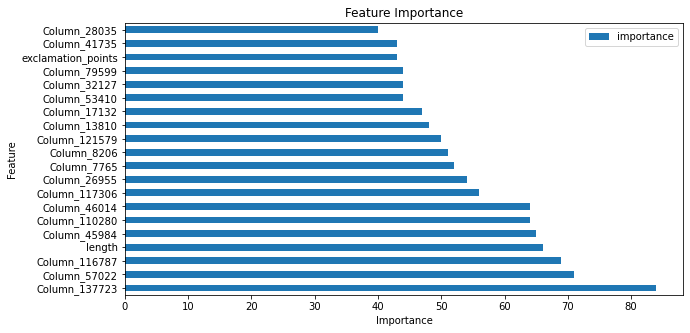

In [77]:
(
    importances
    .sort_values(by='importance', ascending=False)
    .head(20)
    .plot(x='feature', kind='barh', figsize=(10, 5))
)

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [78]:
importances.loc[~importances['feature'].isin(['exclamation_points', 'length']), 'feature'] = 'tf_idf'

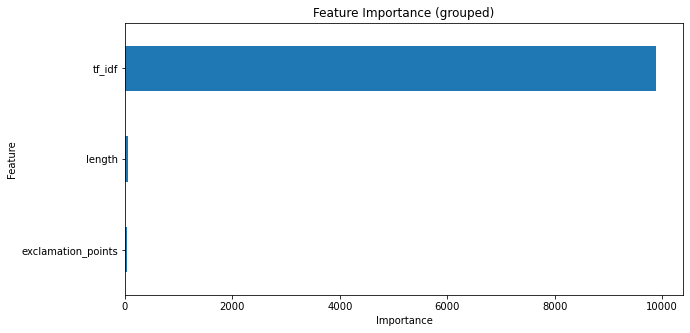

In [79]:
(
    importances
    .groupby('feature')['importance']
    .sum()
    .sort_values()
    .plot(kind='barh', figsize=(10, 5))
)

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (grouped)')
plt.show()

# 4. Выводы

Предобработка комментариев происходила 2 способами:
1. Расчет величины TF-IDF для слов (основной способ);
2. Расчет ембедингов для слов с помощью нейронной сети BERT (дополнительный способ, применял с целью знакомства с нейронной сетью BERT и фреймворком PyTorch).

Также в признаки были добавлены количество восклицательных знаков и символов в комментарии. Для обучения применялись 4 модели - логистическая регрессия, дерево решений, случайный лес, LightGBM.

В результате анализа проведенной работы и полученных результатов можно сделать следующие выводы:
- лучшей модель стал __LightGBM__. Он показал лучшее значение __F1__ на __кросс-валидации__ (__0.764__);
- __F1__ на __тестовой метрике__ для лучшей модели равняется __0.765__, что является достаточным для выполнения поставленной задачи и в целом является более-менее приемлемым результатом;
- модель в некоторой степени переобучена, но и в ходе кросс-валидации, и проверки на тестовой выборке разница значений F1 между обучающей и тестовой (валидационной, в случае кросс-валидации) меньше 0.1.

Важно отметить, что ввиду ограниченности по времени, ресурсам и учебному характеру проекта:
- для всех моделей не были подобраны оптимальные гиперпараметры;
- подбор гиперпараметров для моделей, работающих с комментариями, предобработанными BERT, осуществлялся следующим образом - в сетку параметров кросс-валидации были добавлены стандартные параметры моделей и параметры моделей, с которыми были получены лучшие результаты на TF-IDF. Очевидно, что это плохой способ подбора гиперпараметров. Но в данном проекте работа с BERT не была обязательной, и, с учетом указанных ограничений, это была попытка лишь ознакомиться с возможностями BERT. Из полученных результатов можно сделать вывод, что классификация на ембедингах BERT с минимальной оптимизацией дала результаты, не кардинально уступающие преобразованию к TD-IDF. Можно заключить, что при более полноценном подборе оптимальных значений гиперпараметров (что, безусловно, необходимо в реальных условиях) оба варианта предобработки и все модели могли бы дать лучшие результаты.

Если взглянуть на графики значимости признаков, можно заметить, что:
- если объединить все признаки, относящиеся к TF-IDF, то количество восклицательных знаков и символов имеют очень маленькую, но не нулевую значимость;
- если же не объединять признаки, относящиеся к TF-IDF, то указанные параметры входят в ТОП-20 значимых параметров.

Из этого можно сделать вывод, что количество восклицательных знаков и символов являются значимыми параметрами и их стоит оставить в качестве признаков для классификации токсичности комментариев.

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны